# Drum sequencer VAE evaluation

In [1]:
%reload_ext autoreload

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.set_loglevel("info")

import seaborn as sns
sns.set_theme(style="whitegrid")

In [2]:
from collections import OrderedDict, defaultdict
from datetime import datetime
from google.cloud import storage
from itertools import islice
import math
import numpy as np
import onnx
import onnxruntime
import os
from pathlib import Path
import torch
import torch.nn as nn
import time
from tqdm import tqdm
from typing import Tuple
import wandb
import yaml

from dsvae.data.loader import NoteSequenceDataLoader
from dsvae.models.vae import VAE
from dsvae.utils.hparams import HParams

## Setup

Interesting runs:
- elated-serenity-195
- magic-eon-196
- proud-resonance-206

In [3]:
# env
# os.environ["DEBUG"] = "1"

# RUN_PATH = "mxkrn/drum-sequencer-vae-dsvae/1hj953io"
# RUN_NAME = "elated-serenity-195"
# RUN_NAME = "magic-eon-196"
# RUN_PATH = "mxkrn/drum-sequencer-vae-dsvae/a9zwogu7"
RUN_NAME = "proud-resonance-206"
RUN_PATH = "mxkrn/drum-sequencer-vae-dsvae/2vy0x403"
DEVICE = "cuda:0"
ONNX = True

BATCH_SIZE = 10

### Load data

In [4]:
path_to_data = Path(os.environ["DATA_SOURCE_DIR"])
data_loader = NoteSequenceDataLoader(
    path_to_data=path_to_data,
    batch_size=BATCH_SIZE,
    split="test",
    file_shuffle=True,
    pattern_shuffle=False,
    scale_factor=1,
    num_workers=0
)

Failed loading /home/max/data/gmd/full/drummer6/session1/4_rock_80_beat_6-8.mid
Failed loading /home/max/data/gmd/full/drummer1/session2/111_rock-prog_110_beat_5-4.mid


In [5]:
def get_hparams(run_path):
        # get hyperparameters
    config = yaml.load(wandb.restore(f"config.yaml", run_path=run_path, replace=True), Loader=yaml.FullLoader)
    hparams = {}
    for k, v in config.items():
        if not k in ["_wandb", "wandb_version"]:
            if isinstance(v, dict):
                hparams[k] = v["value"]
    hparams = HParams(hparams)
    hparams.batch_size = BATCH_SIZE
    return hparams

def get_model(run_path: str, run_name: str) -> nn.Module:
    # get hyperparameters
    hparams = get_hparams(run_path)

    # load model
    path_to_state_dict = f"outputs/models/{run_name}/latest.pt"
    load_path =  Path.cwd().parent / path_to_state_dict
    save_path = Path(path_to_state_dict).with_suffix(".onnx")
    _state_dict_io = wandb.restore(path_to_state_dict, run_path=RUN_PATH)
    model = VAE(hparams)
    model.load_state_dict(torch.load(_state_dict_io.name))
    model = model.to(DEVICE)
    
    return model.eval()

def get_onnx_model_path(run_name: str):
    onnx_model_path = f"outputs/models/{run_name}/{run_name}.onnx"
    load_path =  Path.cwd().parent / onnx_model_path
    assert load_path.is_file()
    model = onnx.load(load_path)
    onnx.checker.check_model(model)
    return load_path

In [6]:
hparams = get_hparams(RUN_PATH)
ONNX_MODEL_PATH = get_onnx_model_path(RUN_NAME)
model = get_model(RUN_PATH, RUN_NAME)

## Evaluation

We want to evaluate on several custom metrics:
1. Missing notes
2. Added notes

We will evaluate these metrics in several different scenarios, we expect specific results for each scenario.

### Teacher force ratio

In this panel, we analyze what happens when we use different teacher force ratios.

In [7]:
THRESHOLD = torch.tensor(0.5)

def get_onsets(tensor, threshold = THRESHOLD) -> torch.Tensor:
    ones = torch.tensor(1., device=tensor.device)
    zeros = torch.tensor(0., device=tensor.device)
    onsets = torch.where(tensor[:, :, :9] >= threshold, ones, zeros)
    return onsets

def get_velocities(tensor) -> torch.Tensor:
    return tensor[:, :, 9:18]

def get_offsets(tensor) -> torch.Tensor:
    return tensor[:, :, 18:27]

def preprocess(pattern):
    pattern = torch.transpose(pattern, 1, 2)
    pattern = torch.flip(pattern, [0, 1])
    return pattern.detach().cpu().numpy()

def normalize(pattern):
    max = np.max(pattern)
    return np.divide(pattern, torch.full(pattern.shape, max))

In [8]:
def onnx_predict(input: torch.Tensor, delta_z: torch.Tensor, note_dropout :torch.Tensor, onnx_model_path: str):
    session = onnxruntime.InferenceSession(onnx_model_path)

    ort_inputs = {
        'input': input.detach().cpu().numpy(),
        'delta_z': delta_z.cpu().numpy(),
        'note_dropout': note_dropout.unsqueeze(0).cpu().numpy()
    }
    output = session.run(None, ort_inputs)
    return output[0], output[1], output[2], output[3], output[4]

In [9]:
input, target, fname, frame_index = next(iter(data_loader))
delta_z = torch.zeros(hparams.latent_size, dtype=torch.float)
note_dropout = torch.tensor(1., dtype=torch.float)

onsets, velocities, offsets, z, z_loss = onnx_predict(input, delta_z, note_dropout, str(ONNX_MODEL_PATH))
output = np.concatenate([onsets, velocities, offsets], axis=-1)
output = torch.tensor(output, device=DEVICE, dtype=torch.float)
output_onsets = get_onsets(output)

In [10]:
output_data = OrderedDict()
teacher_force_ratios = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
data = [x for x in data_loader]
num_data_points = len(data)
sum_input_notes = defaultdict(list)
sum_output_notes = defaultdict(list)
sum_latent_vectors = defaultdict(list)
sum_outputs = defaultdict(list)

# num_data_points = 10

for ratio in teacher_force_ratios:
    output_data[ratio] = {}
    output_data[ratio]["input_onsets"] = []
    output_data[ratio]["output_onsets"] = []
    print(f"------------------------ RATIO = {ratio} ------------------------")
    
    # input
    delta_z = torch.zeros(
        (hparams.latent_size), dtype=torch.float, device=DEVICE
    )
    teacher_force_ratio = torch.tensor(ratio, dtype=torch.float, device=DEVICE)
    threshold = 0.5

    missing_notes = []
    added_notes = []
    count = 0

    for input, target, fname, frame_index in tqdm(islice(data, 2000)):
        input = input.to(DEVICE, non_blocking=True)
        
        if ONNX:
            onsets, velocities, offsets, z, z_loss = onnx_predict(input, delta_z, teacher_force_ratio, str(ONNX_MODEL_PATH))
            output = np.concatenate([onsets, velocities, offsets], axis=-1)
            output = torch.tensor(output, device=DEVICE, dtype=torch.float)
        else:
            onsets, velocities, offsets, z, z_loss = model(input, delta_z, teacher_force_ratio)
            output = torch.cat((onsets, velocities, offsets), -1)

        # get onsets
        output_onsets = get_onsets(output)
        input_onsets = get_onsets(input)
        delta = torch.ne(output_onsets, input_onsets).int()
        
        # append to example osnets
        if len(output_data[ratio]["input_onsets"]) < 4:
            output_data[ratio]["input_onsets"].append(preprocess(input_onsets))
        if len(output_data[ratio]["output_onsets"]) < 4:
            output_data[ratio]["output_onsets"].append(preprocess(output_onsets))
        
        # get missing notes
        missing = torch.mul(delta, input_onsets)
        missing_notes.append(torch.sum(missing).item())
        
        # get added notes
        added = torch.mul(delta, output_onsets)
        added_notes.append(torch.sum(added).item())
        
        # add sum of notes
        sum_input_notes[ratio].append(torch.sum(input_onsets).item())
        sum_output_notes[ratio].append(torch.sum(output_onsets).item())
        
        # get z-coordinates
        sum_latent_vectors[ratio].append(z)
        sum_outputs[ratio].append(output)
        
        if count == 0:
            total_added = added
            total_missing = missing
            count += 1
        else:
            total_added = torch.add(total_added, added)
            total_missing = torch.add(total_missing, missing)
    
    output_data[ratio]["total_added"] = total_added.view(-1, total_added.shape[1]*total_added.shape[2])
    output_data[ratio]["total_missing"] = total_missing.view(-1, total_missing.shape[1]*total_missing.shape[2])
    heatmap_added = preprocess(total_added)
    output_data[ratio]["heatmap_added"] = normalize(heatmap_added)
    heatmap_missing = preprocess(total_missing)
    output_data[ratio]["heatmap_missing"] = normalize(heatmap_missing)

1it [00:00,  8.60it/s]

------------------------ RATIO = 1.0 ------------------------


220it [00:23,  9.45it/s]
1it [00:00,  9.72it/s]

------------------------ RATIO = 0.8 ------------------------


220it [00:22,  9.58it/s]
1it [00:00,  8.24it/s]

------------------------ RATIO = 0.6 ------------------------


220it [00:24,  8.89it/s]
1it [00:00,  6.94it/s]

------------------------ RATIO = 0.4 ------------------------


220it [00:30,  7.30it/s]
1it [00:00,  6.72it/s]

------------------------ RATIO = 0.2 ------------------------


220it [00:30,  7.14it/s]
1it [00:00,  6.92it/s]

------------------------ RATIO = 0.0 ------------------------


220it [00:31,  7.05it/s]


#### Input - Output Comparison

In the following plots, we compare side-by-side a random sub-sample of input and output onset patterns. We evaluate the outputs for different teacher force ratios.

In [13]:
# def plot_pattern_pair(input, output):
#     fig, axs = plt.subplots(1, 2, figsize=(25, 3))
#     axs[0].set_title("Input pattern")
#     sns.heatmap(input, ax=axs[0])
#     axs[1].set_title("Output pattern")
#     sns.heatmap(output, ax=axs[1])
#     plt.show()

In [14]:
# for ratio in teacher_force_ratios:
#     print(f"------------------ TEACHER FORCE RATIO = {ratio} ------------------\n")
#     input_onsets = output_data[ratio]["input_onsets"]
#     output_onsets = output_data[ratio]["output_onsets"]
    
#     for i, onset in enumerate(input_onsets):
#         plot_pattern_pair(onset, output_onsets[i])
#         continue

#### Added notes

In [26]:
# output_data[teacher_force_ratios[count]]["heatmap_added"].mean(axis=0).shape

------------------------ ADDED NOTES ------------------------



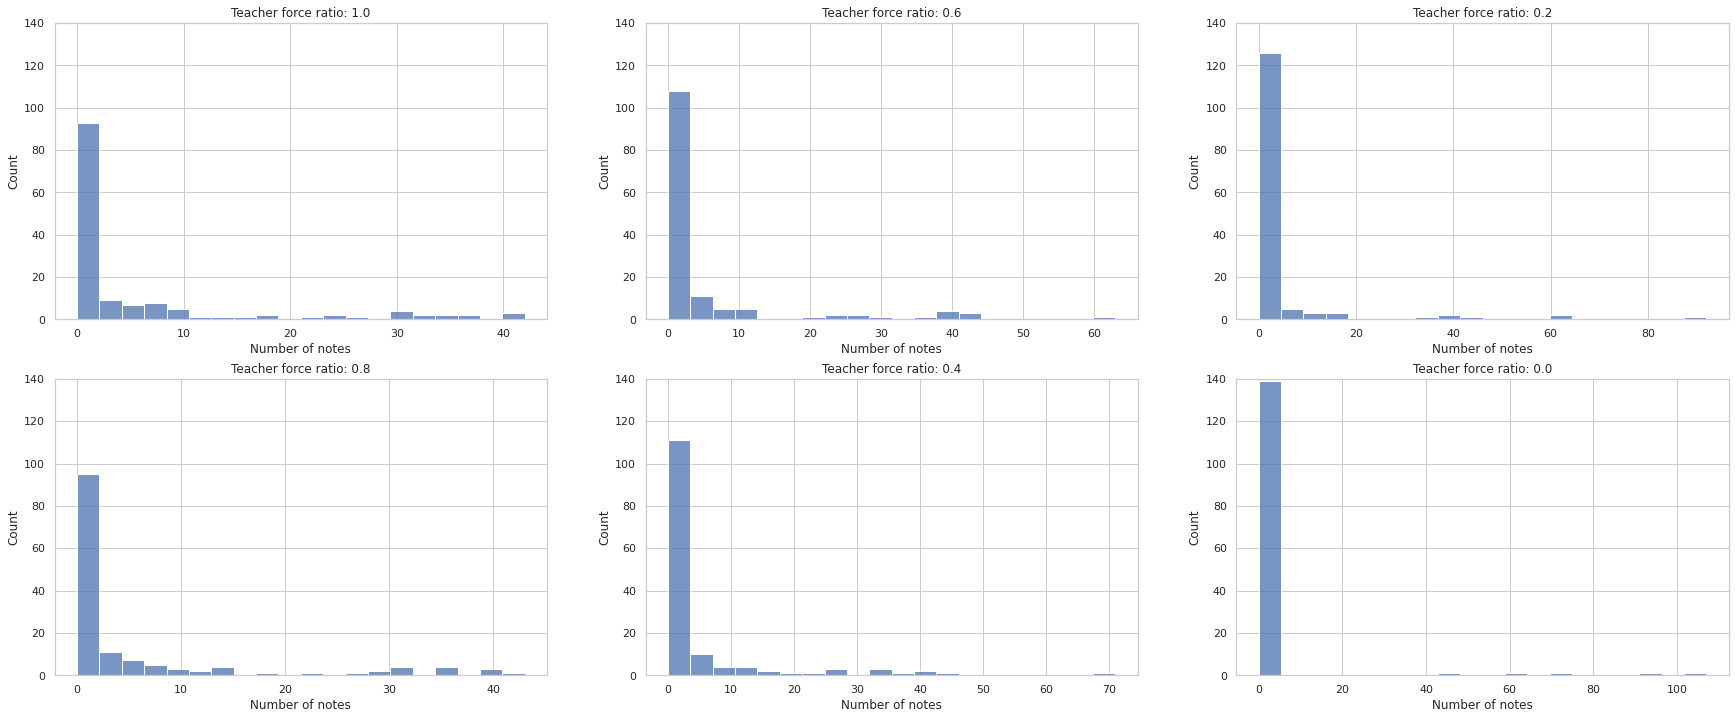

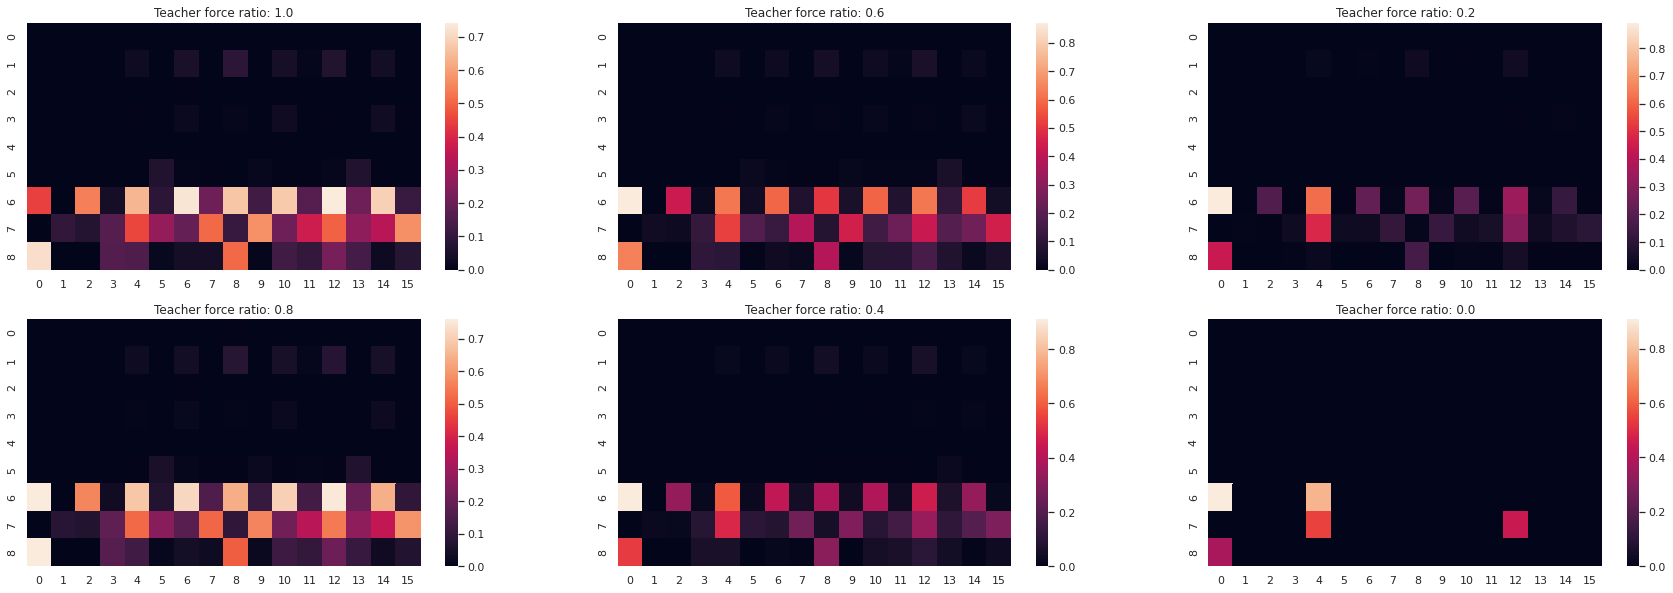

In [27]:
# plot
rows = 2
cols = 3

print(f"------------------------ ADDED NOTES ------------------------\n")
teacher_force_ratios = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
fig, axs = plt.subplots(rows, cols, figsize=(30, 12))
count = 0
for i in range(len(teacher_force_ratios) // rows):
    for j in range(len(teacher_force_ratios) // cols):
        axs[j, i].set_title(f"Teacher force ratio: {teacher_force_ratios[count]}")
        sns.histplot(output_data[teacher_force_ratios[count]]["total_added"].cpu().numpy()[0], ax=axs[j, i], bins=20, stat="count")
        count += 1
        axs[j, i].set_xlabel("Number of notes")
        axs[j, i].set_ylim([0, 140])
        # axs[j, i].set_yscale("log")
plt.show()

fig, axs = plt.subplots(rows, cols, figsize=(30, 10))
count = 0

for i in range(len(teacher_force_ratios) // rows):
    for j in range(len(teacher_force_ratios) // cols):
        axs[j, i].set_title(f"Teacher force ratio: {teacher_force_ratios[count]}")
        sns.heatmap(output_data[teacher_force_ratios[count]]["heatmap_added"].mean(axis=0), ax=axs[j, i])
        count += 1
plt.show()

#### Missing notes

------------------------ MISSING NOTES ------------------------



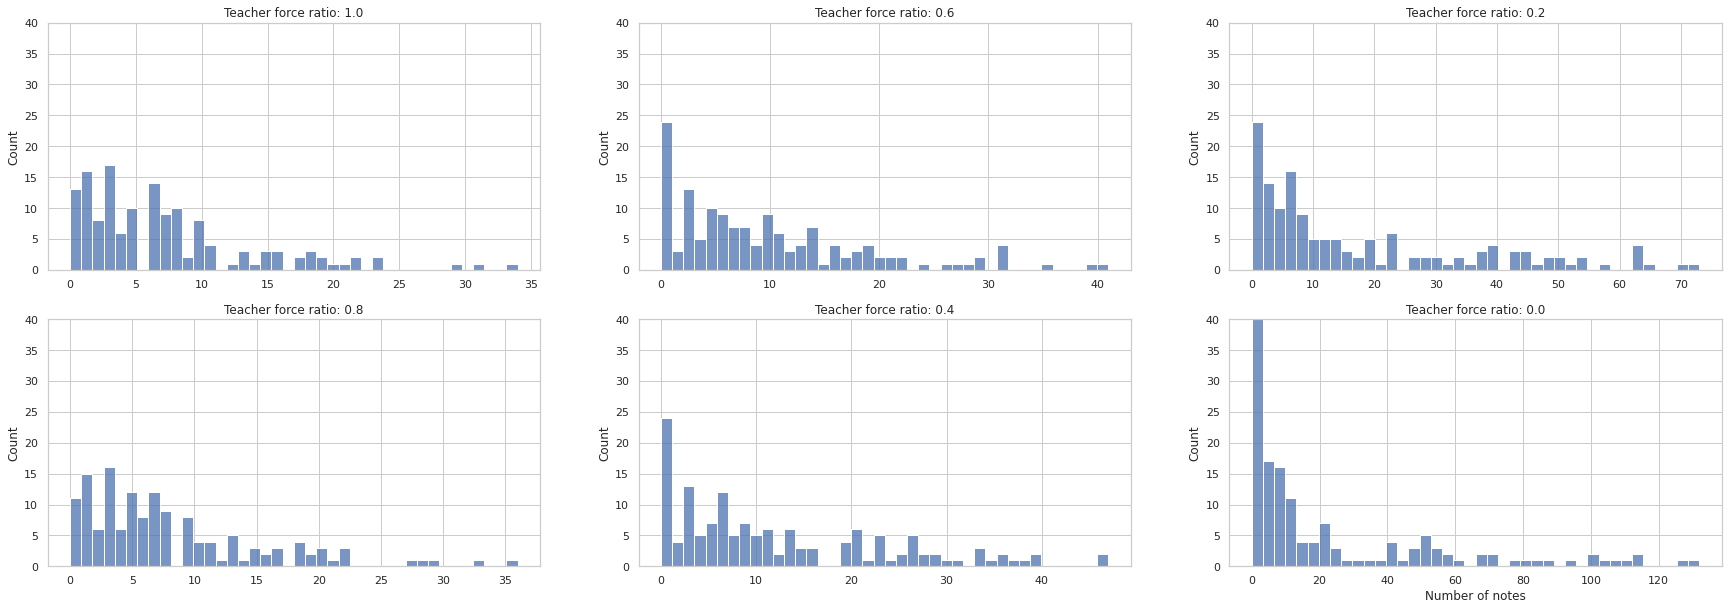

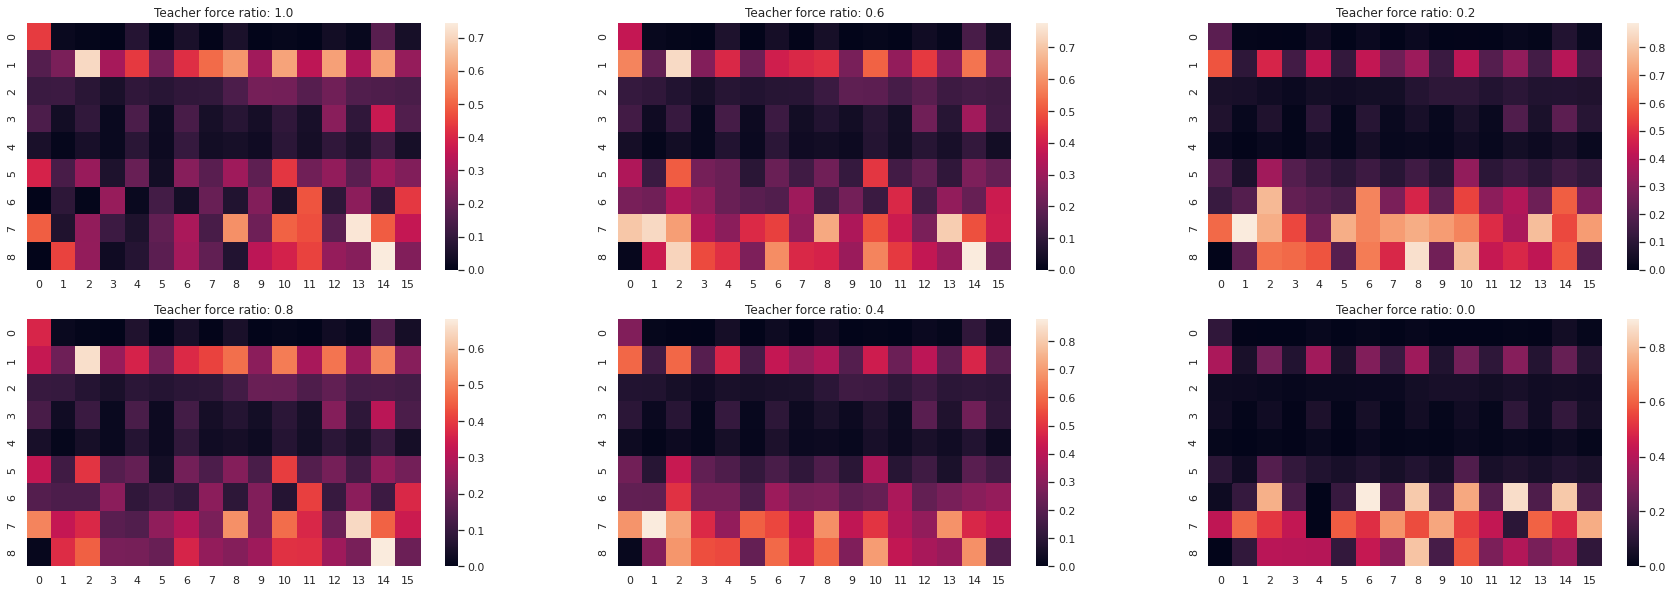

In [28]:
print(f"------------------------ MISSING NOTES ------------------------\n")
fig, axs = plt.subplots(rows, cols, figsize=(30, 10))
count = 0
for i in range(len(teacher_force_ratios) // rows):
    for j in range(len(teacher_force_ratios) // cols):
        axs[j, i].set_title(f"Teacher force ratio: {teacher_force_ratios[count]}")
        sns.histplot(output_data[teacher_force_ratios[count]]["total_missing"].cpu().numpy()[0], ax=axs[j, i], bins=40, stat="count")
        axs[j, i].set_ylim([0, 40])
        count += 1
        plt.xlabel("Number of notes")
plt.show()

fig, axs = plt.subplots(rows, cols, figsize=(30, 10))
count = 0

for i in range(len(teacher_force_ratios) // rows):
    for j in range(len(teacher_force_ratios) // cols):
        axs[j, i].set_title(f"Teacher force ratio: {teacher_force_ratios[count]}")
        sns.heatmap(output_data[teacher_force_ratios[count]]["heatmap_missing"].mean(axis=0), ax=axs[j, i])
        count += 1
plt.show()


#### Average number of notes anomalies per ratio

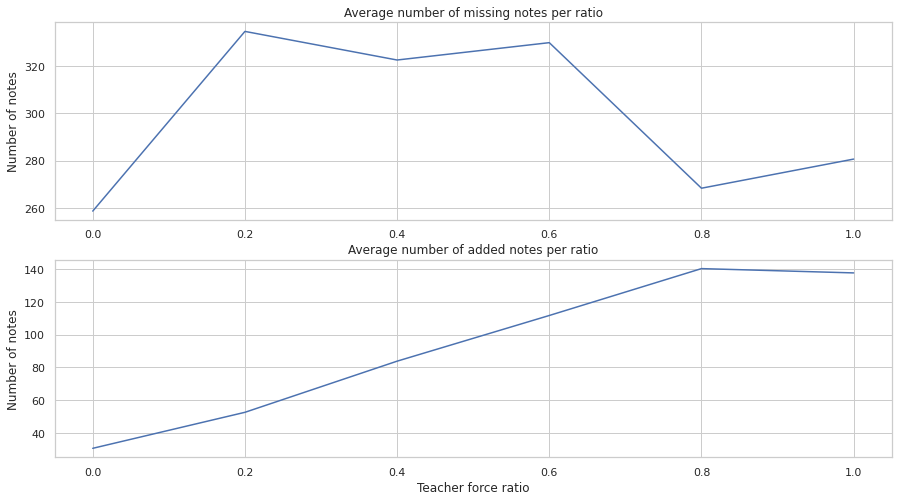

In [29]:
average_missing = []
average_added = []
for i in range(len(teacher_force_ratios)):
    tensor = output_data[teacher_force_ratios[i]]["heatmap_missing"]
    average_missing.append(torch.sum(tensor).item())
    
    tensor = output_data[teacher_force_ratios[i]]["heatmap_added"]
    average_added.append(torch.sum(tensor).item())
    
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].set_title("Average number of missing notes per ratio")
axs[0].plot(teacher_force_ratios, average_missing)
axs[1].set_xlabel("Teacher force ratio")
axs[0].set_ylabel("Number of notes")

axs[1].plot(teacher_force_ratios, average_added)
axs[1].set_title("Average number of added notes per ratio")
axs[1].set_ylabel("Number of notes")
axs[1].set_xlabel("Teacher force ratio")
plt.show()

#### Pattern density

In [30]:
latent_dimension1 = defaultdict(list)
latent_dimension2 = defaultdict(list)
# latent_dimension3 = defaultdict(list)
# latent_dimension4 = defaultdict(list)
for ratio in teacher_force_ratios:
    for batch in sum_latent_vectors[ratio]:
        latent_dimension1[ratio].append(batch[:, 0][0].item())
        latent_dimension2[ratio].append(batch[:, 1][0].item())
#         latent_dimension3[ratio].append(batch[:, 2][0].item())
#         latent_dimension4[ratio].append(batch[:, 3][0].item())

---------------------- RATIO: 1.0 ----------------------


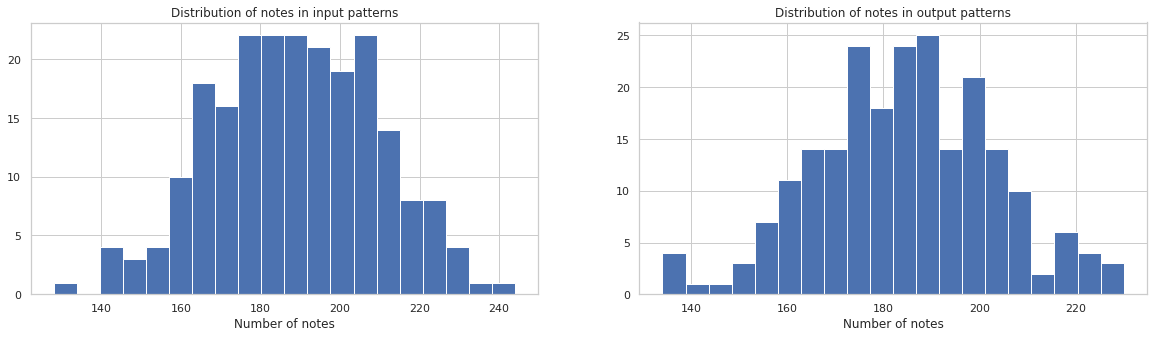

---------------------- RATIO: 0.8 ----------------------


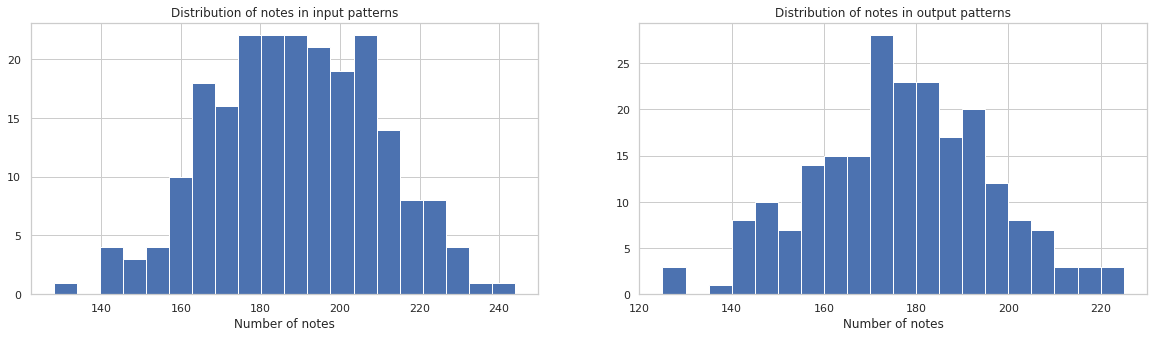

---------------------- RATIO: 0.6 ----------------------


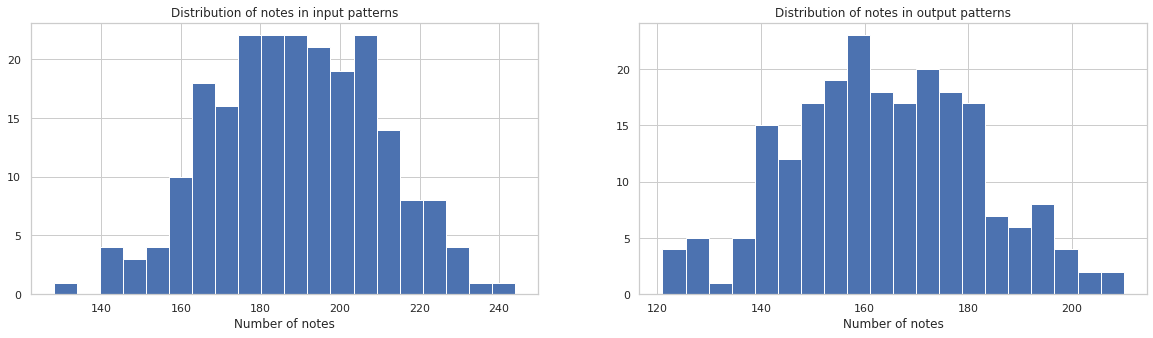

---------------------- RATIO: 0.4 ----------------------


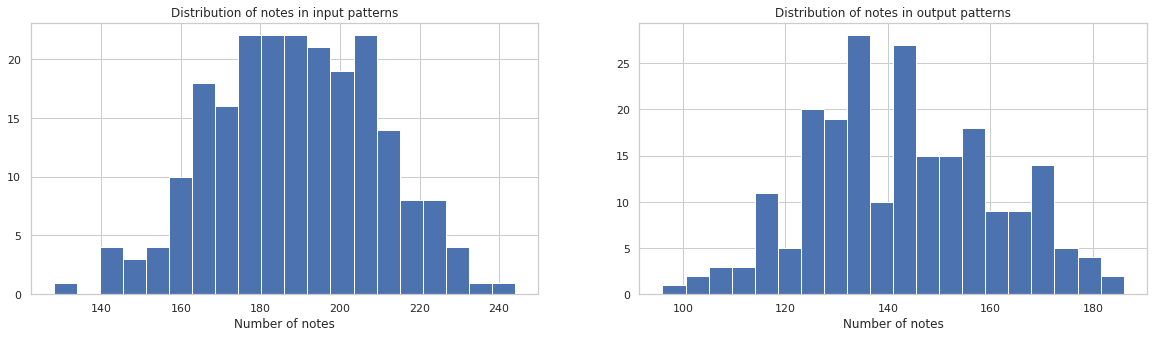

---------------------- RATIO: 0.2 ----------------------


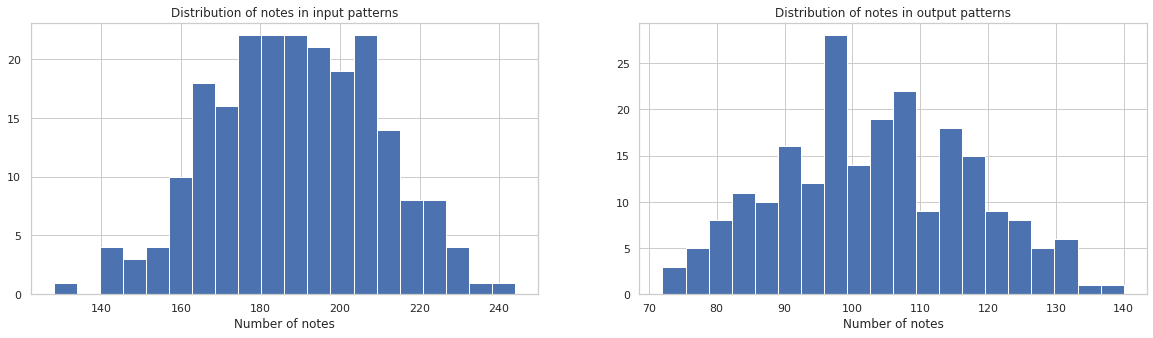

---------------------- RATIO: 0.0 ----------------------


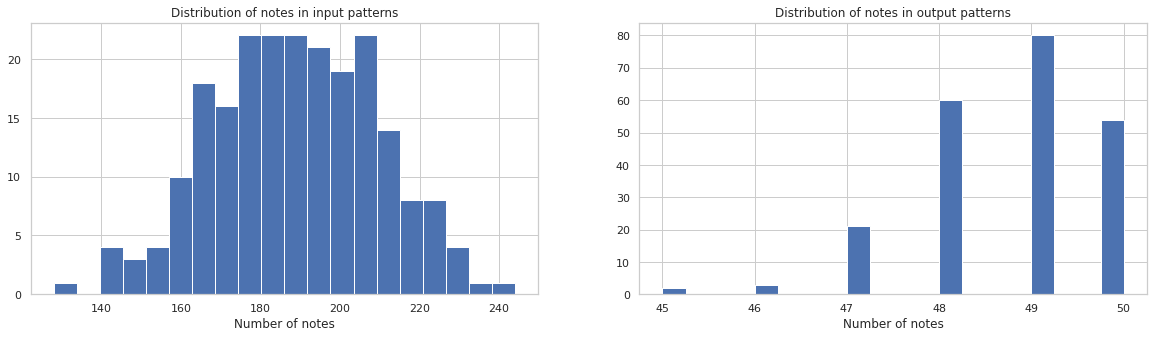

In [31]:
test_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
for ratio in teacher_force_ratios:
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    print(f"---------------------- RATIO: {ratio} ----------------------")
    axs[0].set_title("Distribution of notes in input patterns")
    axs[0].hist(sum_input_notes[ratio], bins=20)
    axs[0].set_xlabel("Number of notes")
    axs[1].set_title("Distribution of notes in output patterns")
    axs[1].hist(sum_output_notes[ratio], bins=20)
    axs[1].set_xlabel("Number of notes")
    plt.show()

#### Latent variable distribution

---------------------- RATIO: 1.0 ----------------------


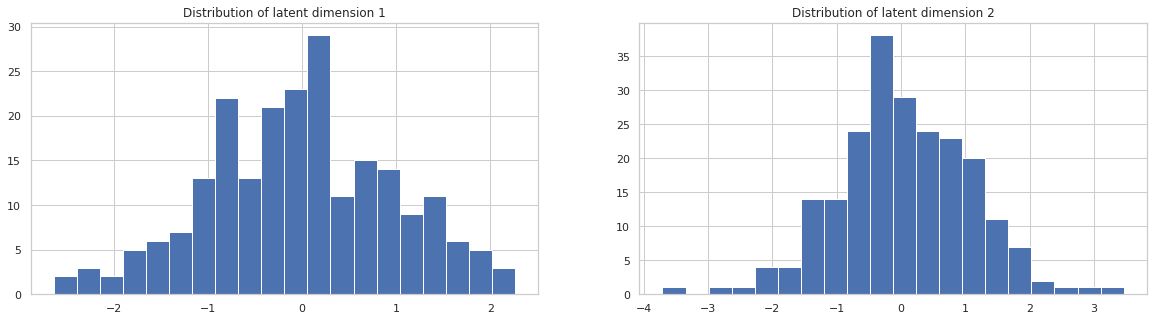

---------------------- RATIO: 0.8 ----------------------


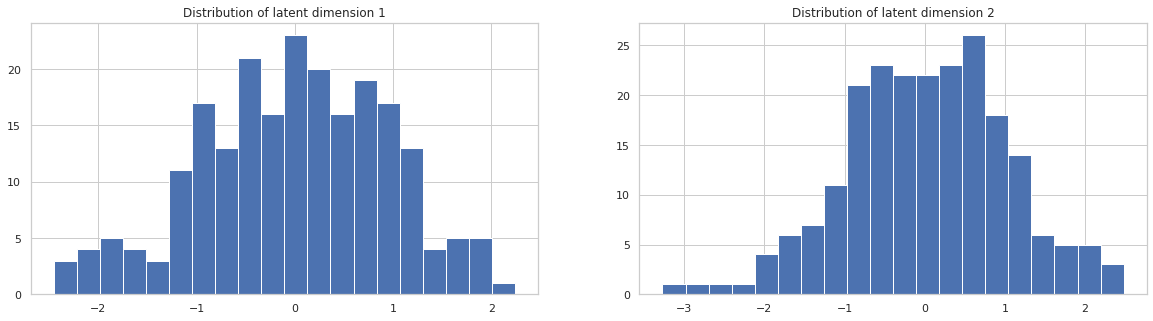

---------------------- RATIO: 0.6 ----------------------


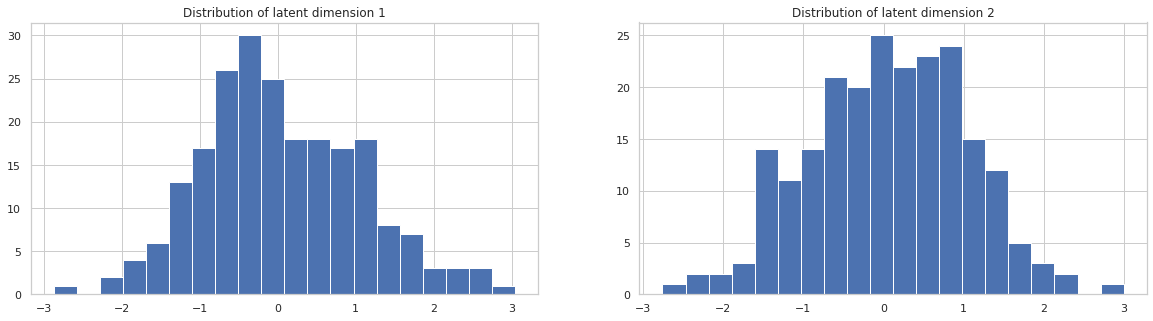

---------------------- RATIO: 0.4 ----------------------


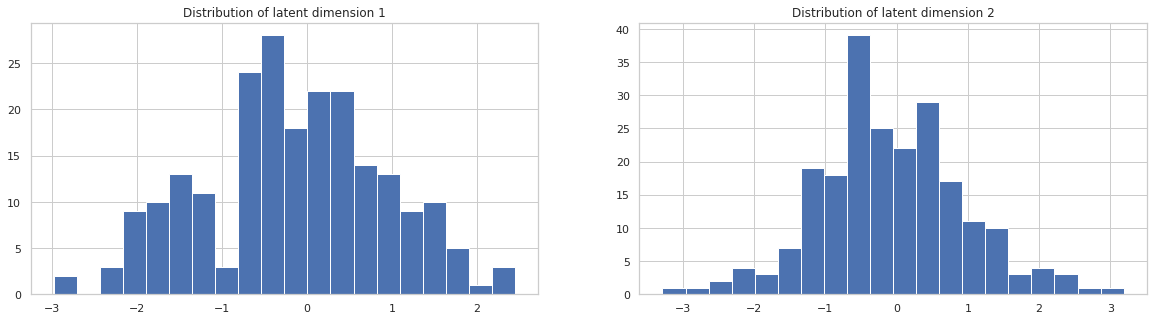

---------------------- RATIO: 0.2 ----------------------


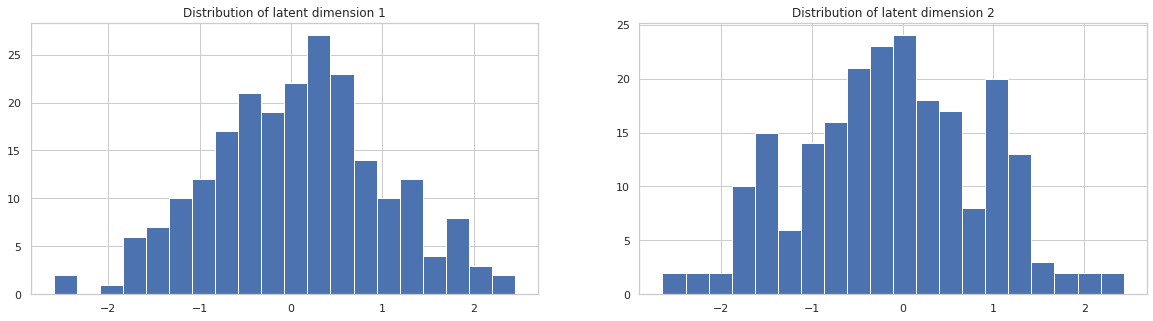

---------------------- RATIO: 0.0 ----------------------


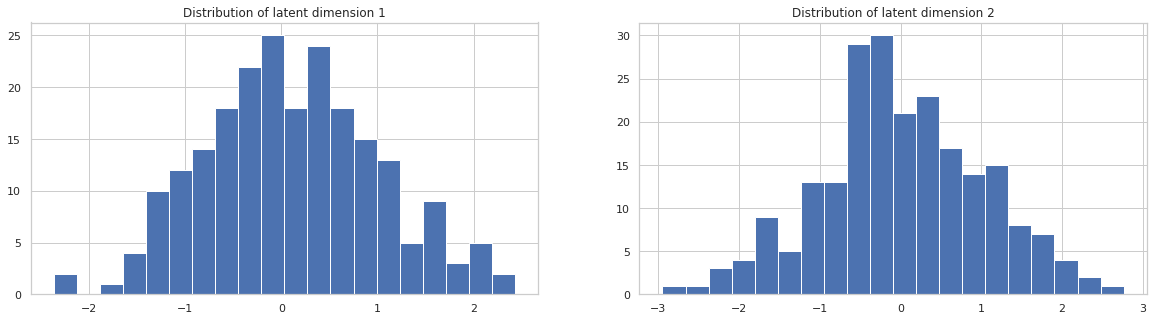

In [32]:
for ratio in teacher_force_ratios:
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    print(f"---------------------- RATIO: {ratio} ----------------------")
    axs[0].set_title("Distribution of latent dimension 1")
    axs[0].hist(latent_dimension1[ratio], bins=20)
    axs[1].set_title("Distribution of latent dimension 2")
    axs[1].hist(latent_dimension2[ratio], bins=20)
#     axs[2].set_title("Distribution of latent dimension 3")
#     axs[2].hist(latent_dimension3[ratio], bins=20)
#     axs[3].set_title("Distribution of latent dimension 4")
#     axs[3].hist(latent_dimension4[ratio], bins=20)
    plt.show()

#### Latent space analysis

1. Teacher force ratio = 1.0
2. Teacher force ratio = 0.5

In [33]:
# reload data
data_loader = NoteSequenceDataLoader(
    path_to_data=path_to_data,
    batch_size=1,
    split="test",
    file_shuffle=True,
    pattern_shuffle=False,
    scale_factor=1,
    num_workers=0
)
# assert sample.shape == (1, 16, 27)

Text(0, 0.5, 'Sigmoid(X)')

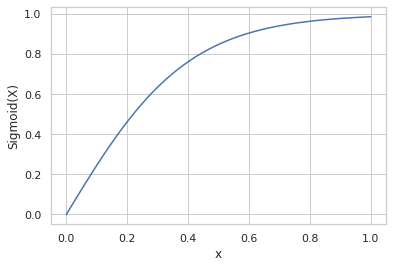

In [34]:
# check sigmoid normalization
def sigmoid(array, gradient=1):
    sigmoid = 1 / (1 + np.exp(np.multiply(array, -gradient)))
    curve = np.subtract(sigmoid, 0.5)
    return np.multiply(curve, 2)

def construct_delta_z(i: int, j: int, dims = [0, 1], num_dims: int = 4, std: float = 1):
    tensor = np.zeros(num_dims)
    for d, _ in enumerate(range(num_dims)):
        if d == dims[0]:
            tensor[d] = (i / num_dims)*std
        elif i == dims[1]:
            tensor[d] = (j / num_dims)*std
        else:
            tensor[d] = 0.
    
    return torch.tensor(tensor, dtype=torch.float)

def plot_pattern(model_output):
    pass

# test sigmoid creation
x = np.linspace(0, 1, 1000)
z = sigmoid(x, 5)
  
plt.plot(x, z) 
plt.xlabel("x") 
plt.ylabel("Sigmoid(X)") 

In [37]:
# ratio = torch.tensor(0.4)

# # get input
# fig, axs = plt.subplots(1, 3, figsize=(40, 5))
# print('\nINPUT\n')
# sample, target, filename, frame_index = next(iter(data_loader))
# repeated_sample = sample.repeat(4, 0, 0)
# sample = sample.to(DEVICE)
# input_onsets = get_onsets(sample)
# input_onsets = preprocess(input_onsets)
# input_velocities = get_velocities(target)
# input_velocities = preprocess(input_velocities)
# input_offsets = get_offsets(target)
# input_offsets = preprocess(input_offsets)

# # input_velocities *= input_onsets
# # print(input_velocities)
# sns.heatmap(input_onsets, ax=axs[0])
# sns.heatmap(input_velocities, ax=axs[1], vmin=0, vmax=1)
# input_offsets *= input_onsets

# sns.heatmap(input_offsets,vmin=-1,vmax=1, ax=axs[2], cmap="coolwarm")
# plt.show()

# patterns = []
# x_size, y_size = (6, 3)
# std = 0.5


# for i in range(x_size):
#     fig, axs = plt.subplots(1, y_size, figsize=(40, 5))
#     print(f'\nOUTPUT {i}\n')
#     subpatterns = []
#     delta_z = construct_delta_z(i, 1, num_dims=model.latent_size, std=0.5)
#     axs[0].set_title(f"Onsets - {delta_z}")
#     axs[1].set_title(f"Velocities - {delta_z}")
#     axs[2].set_title(f"Offsets - {delta_z}")

#     # print(delta_z)
#     output, z, z_loss = model(sample, delta_z, ratio)
    
#     # onsets
#     output_onsets = get_onsets(output)
#     output_onsets = preprocess(output_onsets)
    
#     # velocities
#     output_velocities = get_velocities(output)
#     output_velocities = preprocess(output_velocities)
#     output_velocities = sigmoid(output_velocities, 5)
#     output_velocities *= output_onsets
    
#     # offsets
#     output_offsets = get_offsets(output)
#     output_offsets = preprocess(output_offsets)
#     output_offsets = sigmoid(output_offsets, 8)
#     output_offsets *= output_onsets
    
#     # plot
#     sns.heatmap(output_onsets, ax=axs[0])
#     sns.heatmap(output_velocities, ax=axs[1], vmin=0, vmax=1)
#     sns.heatmap(output_offsets, vmin=-1, vmax=1, ax=axs[2], cmap="coolwarm")
#     plt.show()

#### Simulate application side inference

In [38]:
ratio = torch.tensor(0.4)

sample, target, filename, frame_index = next(iter(data_loader))
sample = sample.to(DEVICE)

# get inputs, velocities, offsets
input_onsets = get_onsets(sample)
input_onsets = preprocess(input_onsets)
input_velocities = get_velocities(target)
input_velocities = preprocess(input_velocities)
input_offsets = get_offsets(target)
input_offsets = preprocess(input_offsets)
input_offsets *= input_onsets

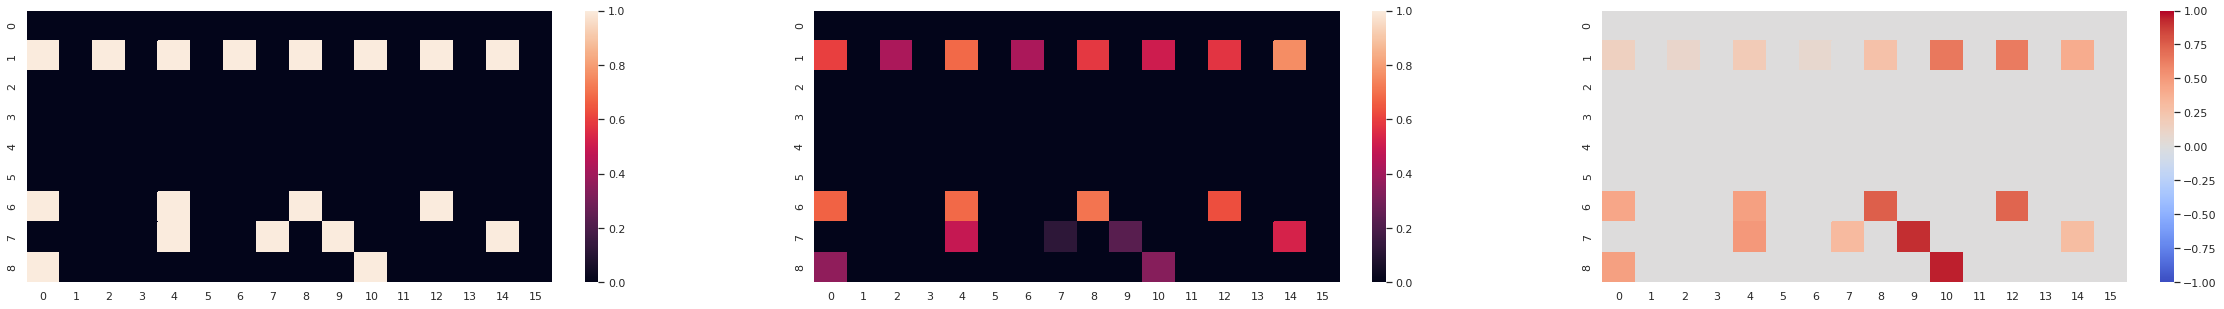

In [39]:
# plot
fig, axs = plt.subplots(1, 3, figsize=(40, 5))
sns.heatmap(input_onsets[0], ax=axs[0])
sns.heatmap(input_velocities[0], ax=axs[1], vmin=0, vmax=1)
sns.heatmap(input_offsets[0], vmin=-1, vmax=1, ax=axs[2], cmap="coolwarm")
plt.show()

In [40]:
def predict(
    input: torch.Tensor,
    delta_z: torch.Tensor,
    onset_threshold_range: Tuple[float, float],
    note_dropout_range: Tuple[float, float],
    onnx_model_path: str,
    output_size: int = 10,
    velocity_scaling: int = 5, 
    offset_scaling: int = 5
):
    session = onnxruntime.InferenceSession(onnx_model_path)
    
    input_grid = input.repeat(output_size, output_size, 1, 1)
    assert input_grid.shape[-1] == input.shape[-1]
    assert input_grid.shape[-2] == input.shape[-2]
    
    onset_thresholds = torch.linspace(onset_threshold_range[0], onset_threshold_range[1], output_size)
    note_dropouts = torch.linspace(note_dropout_range[0], note_dropout_range[1], output_size)
    
    onsets = np.zeros((output_size, output_size, 9,  input.shape[-2]))
    velocities = np.zeros((output_size, output_size, 9, input.shape[-2]))
    offsets = np.zeros((output_size, output_size, 9, input.shape[-2]))
    onset_threshold_lookup = np.zeros((output_size, output_size))
    note_dropout_lookup = np.zeros((output_size, output_size))
    
    for i, input_column in enumerate(input_grid):
        # predict
        onset_threshold = onset_thresholds[i]
        onset_threshold_lookup[i, :] = onset_threshold
        note_dropout = note_dropouts[i]
        note_dropout_lookup[i, :] = note_dropout
        ort_inputs = {
            "input": input_column.detach().cpu().numpy(),
            "delta_z": delta_z.cpu().numpy(),
            "note_dropout": note_dropout.unsqueeze(0).cpu().numpy()
        }
        _onsets, _velocities, _offsets, z, z_loss = session.run(None, ort_inputs)
        output = np.concatenate([_onsets, _velocities, _offsets], axis=-1)
        output = torch.tensor(output, dtype=torch.float)
        
        # onsets
        output_onsets = get_onsets(output, onset_threshold)
        output_onsets = preprocess(output_onsets)
        onsets[i, :] = output_onsets

        # velocities
        output_velocities = get_velocities(output)
        output_velocities = preprocess(output_velocities)
        output_velocities = sigmoid(output_velocities, velocity_scaling)
        velocities[i, :] = output_velocities

        # offsets
        output_offsets = get_offsets(output)
        output_offsets = preprocess(output_offsets)
        output_offsets = sigmoid(output_offsets, offset_scaling)
        offsets[i, :] = output_offsets

    return onsets, velocities, offsets, onset_threshold_lookup, note_dropout_lookup

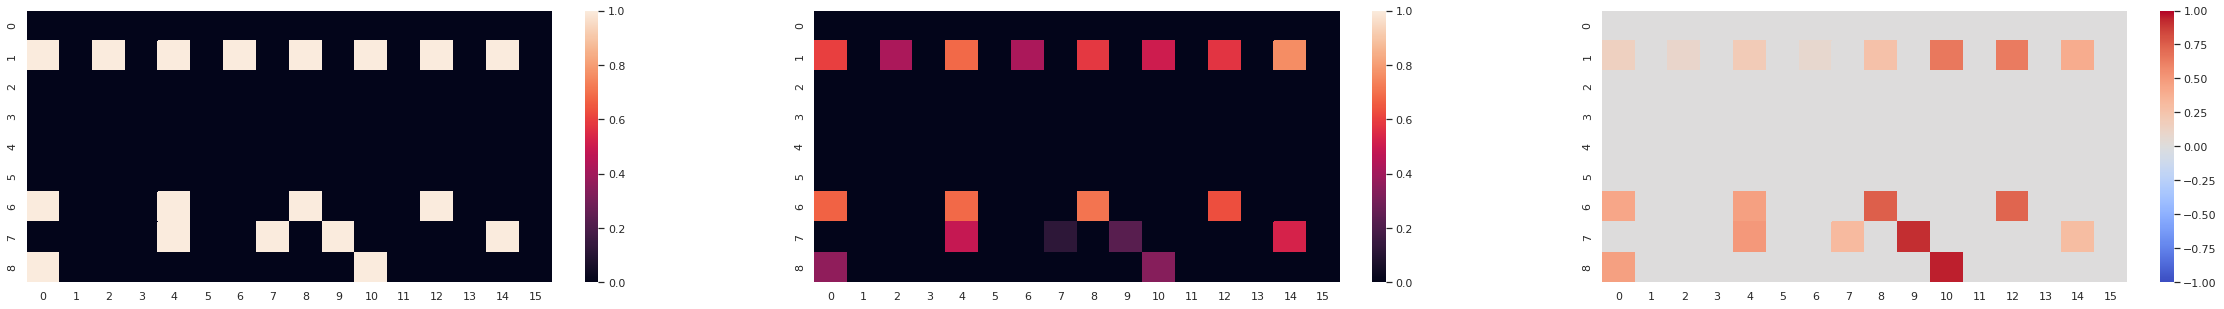

In [41]:
# get inputs, velocities, offsets
input_onsets = get_onsets(sample)
input_onsets = preprocess(input_onsets)
input_velocities = get_velocities(target)
input_velocities = preprocess(input_velocities)
input_offsets = get_offsets(target)
input_offsets = preprocess(input_offsets)
input_offsets *= input_onsets

# plot
fig, axs = plt.subplots(1, 3, figsize=(40, 5))
sns.heatmap(input_onsets[0], ax=axs[0])
sns.heatmap(input_velocities[0], ax=axs[1], vmin=0, vmax=1)
sns.heatmap(input_offsets[0], vmin=-1, vmax=1, ax=axs[2], cmap="coolwarm")
plt.show()

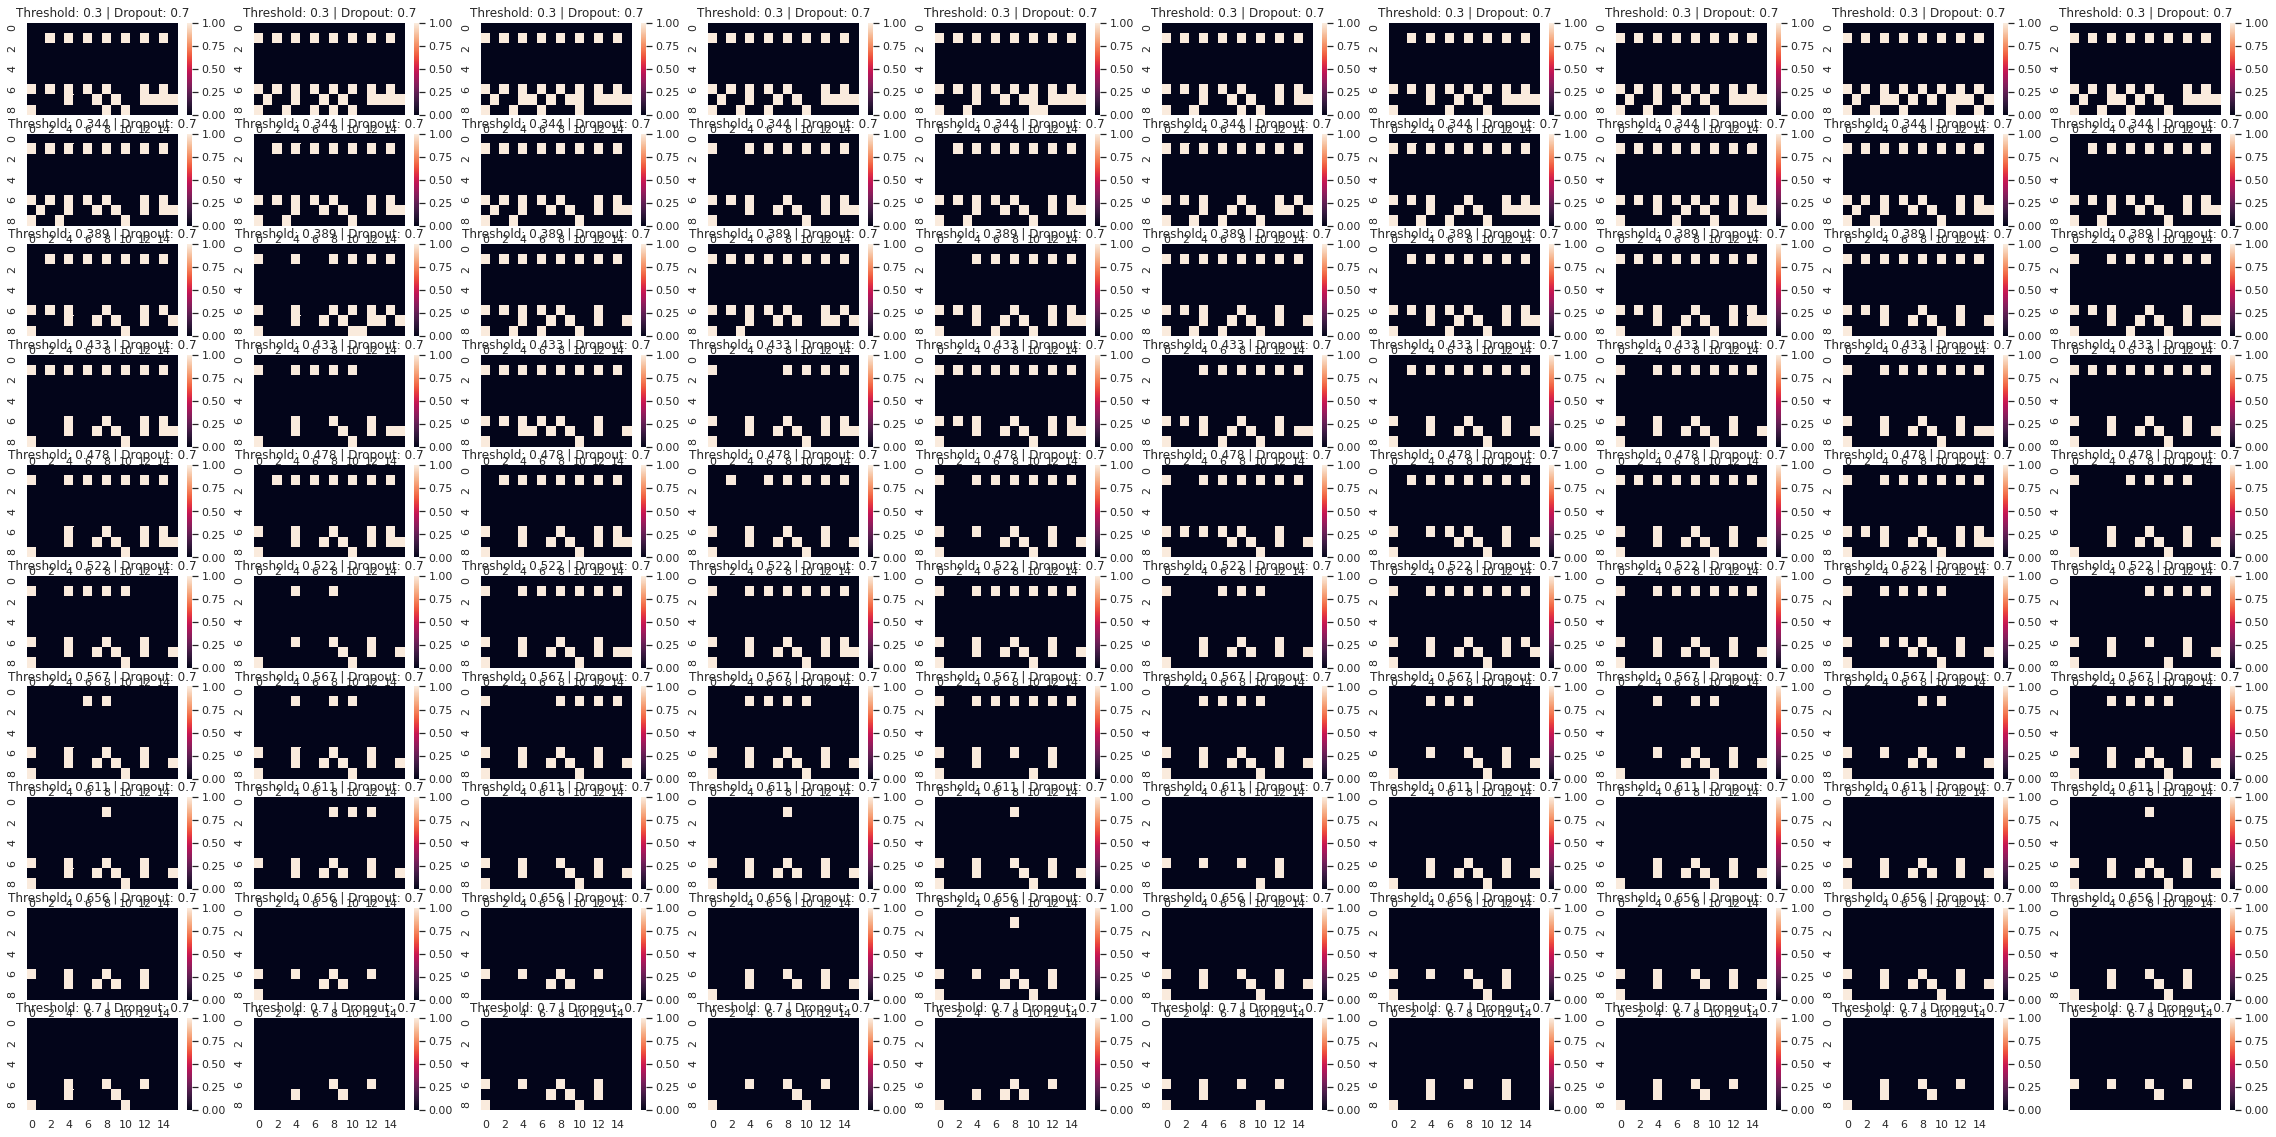

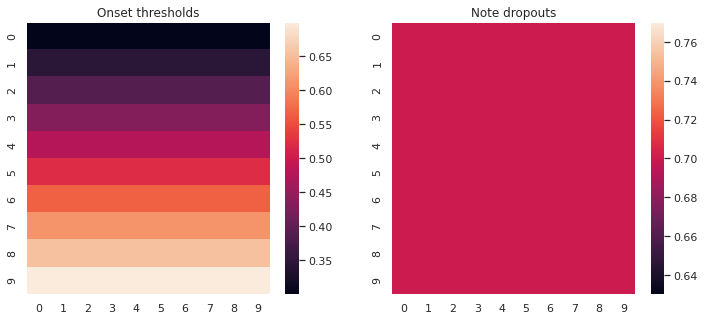

In [42]:
ONSET_THRESHOLD_RANGE = [0.3, 0.7]
NOTE_DROPOUT_RANGE = [0.7, 0.7]
onsets, velocities, offsets, onset_thresholds, note_dropouts = predict(sample, torch.zeros(model.latent_size), ONSET_THRESHOLD_RANGE, NOTE_DROPOUT_RANGE, str(ONNX_MODEL_PATH))

# plot
axes_size = 10
fig, axs = plt.subplots(axes_size, axes_size, figsize=(40, 20))
plt.axis('off')

for i in range(axes_size):
    for j in range(axes_size):
        axs[i, j].set_title(f"Threshold: {round(onset_thresholds[i, j], 3)} | Dropout: {round(note_dropouts[i, j], 3)}")
        sns.heatmap(onsets[i][j], ax=axs[i, j])
plt.show()


fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].set_title("Onset thresholds")
sns.heatmap(onset_thresholds, ax=axs[0])
axs[1].set_title("Note dropouts")
sns.heatmap(note_dropouts, ax=axs[1])
plt.show()

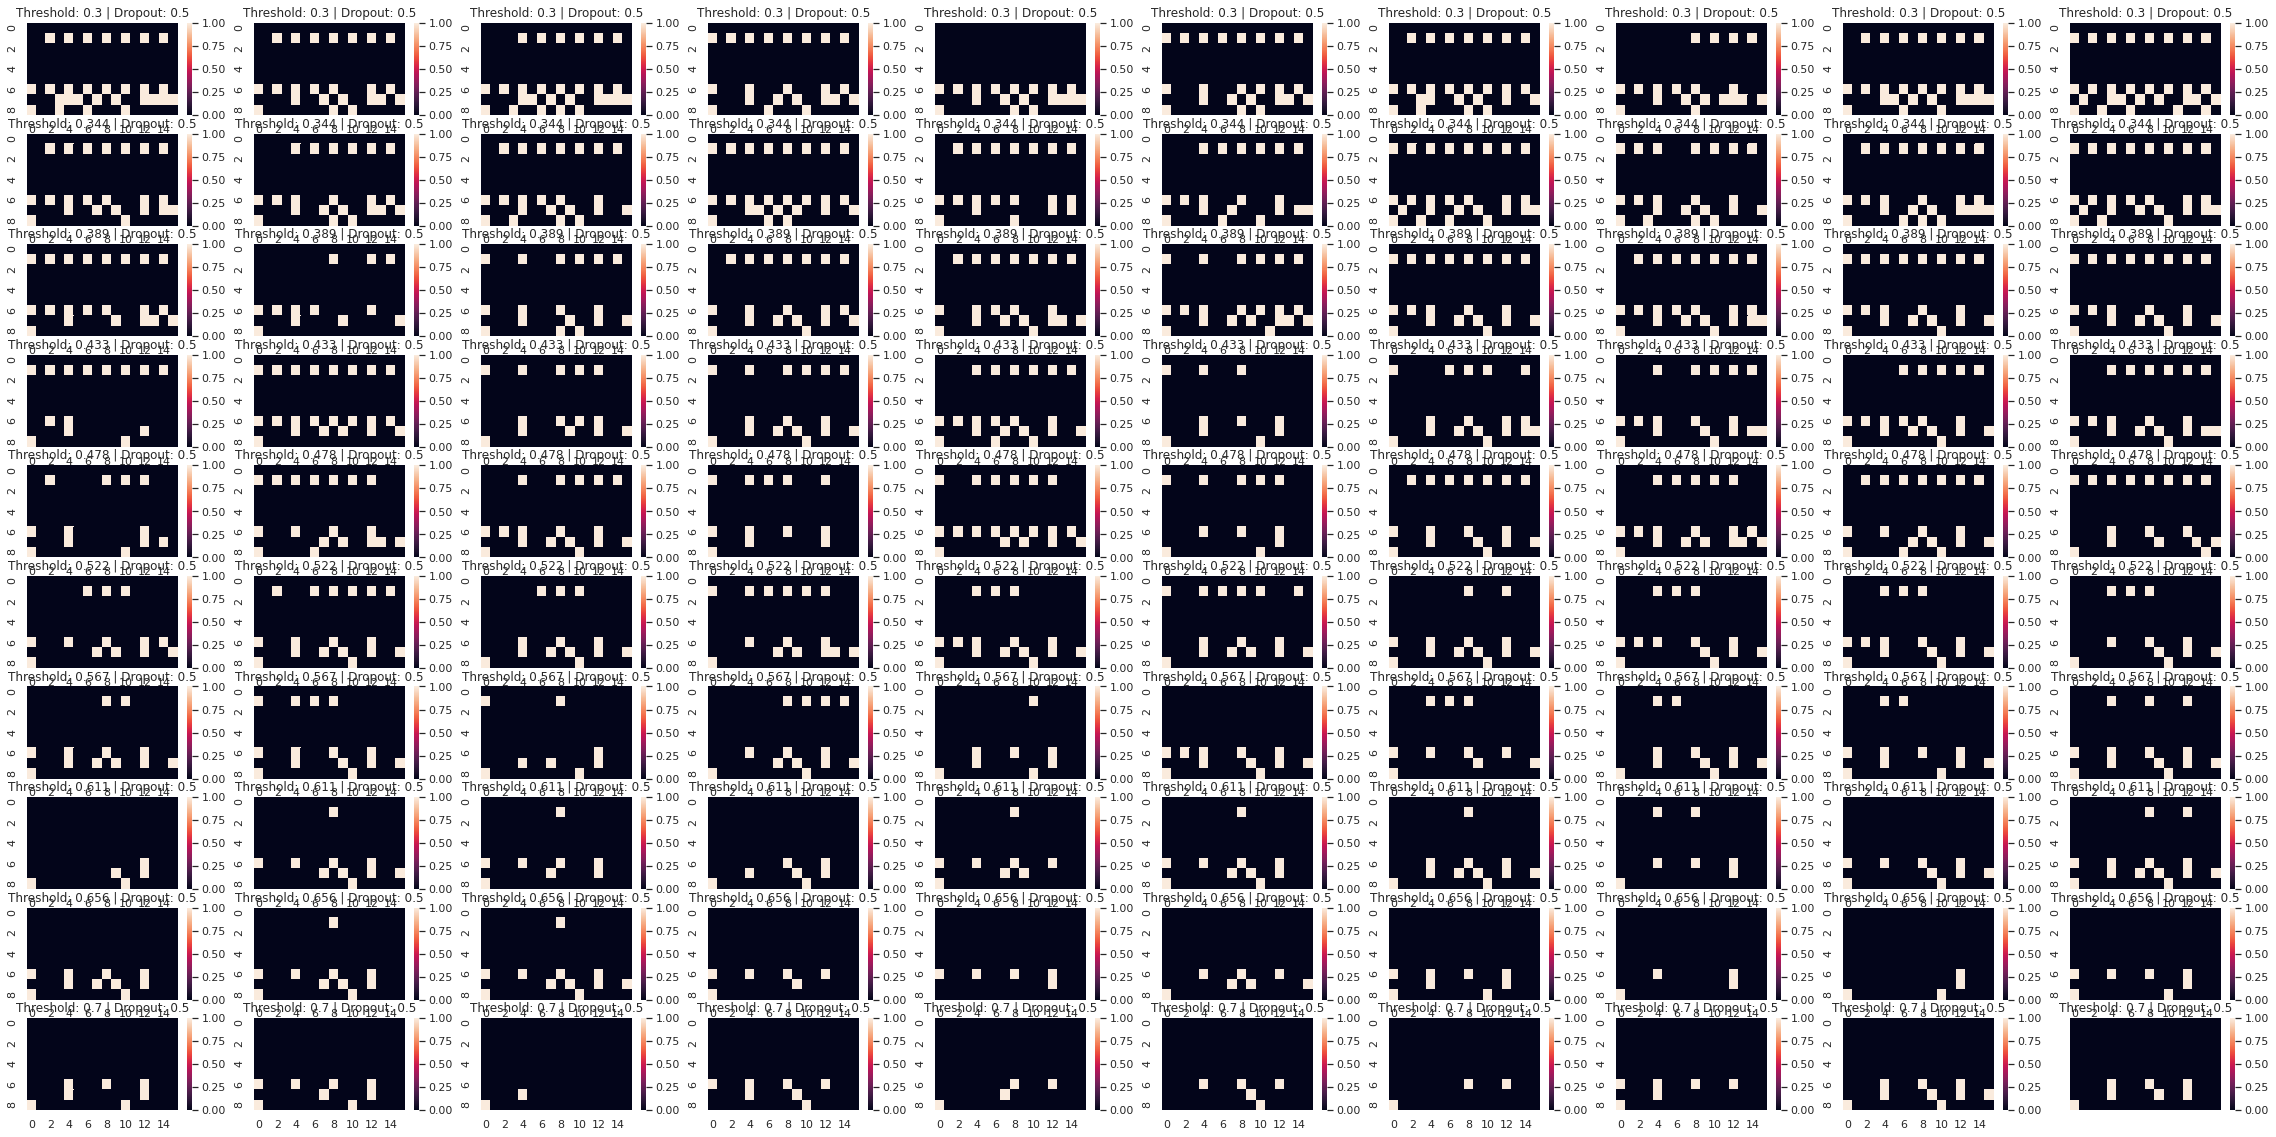

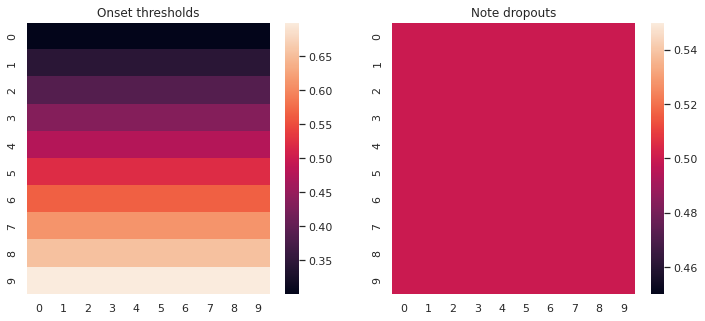

In [43]:
ONSET_THRESHOLD_RANGE = [0.3, 0.7]
NOTE_DROPOUT_RANGE = [0.5, 0.5]
onsets, velocities, offsets, onset_thresholds, note_dropouts = predict(sample, torch.zeros(model.latent_size), ONSET_THRESHOLD_RANGE, NOTE_DROPOUT_RANGE, str(ONNX_MODEL_PATH))

# plot
axes_size = 10
fig, axs = plt.subplots(axes_size, axes_size, figsize=(40, 20))
plt.axis('off')

for i in range(axes_size):
    for j in range(axes_size):
        axs[i, j].set_title(f"Threshold: {round(onset_thresholds[i, j], 3)} | Dropout: {round(note_dropouts[i, j], 3)}")
        sns.heatmap(onsets[i][j], ax=axs[i, j])
plt.show()


fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].set_title("Onset thresholds")
sns.heatmap(onset_thresholds, ax=axs[0])
axs[1].set_title("Note dropouts")
sns.heatmap(note_dropouts, ax=axs[1])
plt.show()

In [ ]:
ONSET_THRESHOLD_RANGE = [0.3, 0.7]
NOTE_DROPOUT_RANGE = [0.7, 0.7]
onsets, velocities, offsets, onset_thresholds, note_dropouts = predict(sample, torch.zeros(model.latent_size), ONSET_THRESHOLD_RANGE, NOTE_DROPOUT_RANGE, str(ONNX_MODEL_PATH))

# plot
axes_size = 10
fig, axs = plt.subplots(axes_size, axes_size, figsize=(40, 20))
plt.axis('off')

for i in range(axes_size):
    for j in range(axes_size):
        axs[i, j].set_title(f"Threshold: {round(onset_thresholds[i, j], 3)}")
        sns.heatmap(onsets[i][j], ax=axs[i, j])
plt.show()


fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].set_title("Onset thresholds")
sns.heatmap(onset_thresholds, ax=axs[0])
axs[1].set_title("Note dropouts")
sns.heatmap(note_dropouts, ax=axs[1])
plt.show()

In [ ]:
ONSET_THRESHOLD_RANGE = [0.3, 0.7]
NOTE_DROPOUT_RANGE = [0.9, 0.9]
onsets, velocities, offsets, onset_thresholds, note_dropouts = predict(sample, torch.zeros(model.latent_size), ONSET_THRESHOLD_RANGE, NOTE_DROPOUT_RANGE, str(ONNX_MODEL_PATH))

# plot
axes_size = 10
fig, axs = plt.subplots(axes_size, axes_size, figsize=(40, 20))
plt.axis('off')

for i in range(axes_size):
    for j in range(axes_size):
        axs[i, j].set_title(f"Threshold: {round(onset_thresholds[i, j], 3)}")
        sns.heatmap(onsets[i][j], ax=axs[i, j])
plt.show()


fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].set_title("Onset thresholds")
sns.heatmap(onset_thresholds, ax=axs[0])
axs[1].set_title("Note dropouts")
sns.heatmap(note_dropouts, ax=axs[1])
plt.show()

In [36]:
ONSET_THRESHOLD_RANGE = [0.1, 0.7]
NOTE_DROPOUT_RANGE = [0.9, 0.9]
onsets, velocities, offsets, onset_thresholds, note_dropouts = predict(sample, torch.zeros(model.latent_size), ONSET_THRESHOLD_RANGE, NOTE_DROPOUT_RANGE, str(ONNX_MODEL_PATH))

# plot
axes_size = 10
fig, axs = plt.subplots(axes_size, axes_size, figsize=(40, 20))
plt.axis('off')

for i in range(axes_size):
    for j in range(axes_size):
        axs[i, j].set_title(f"Threshold: {round(onset_thresholds[i, j], 3)}")
        sns.heatmap(onsets[i][j], ax=axs[i, j])
plt.show()


fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].set_title("Onset thresholds")
sns.heatmap(onset_thresholds, ax=axs[0])
axs[1].set_title("Note dropouts")
sns.heatmap(note_dropouts, ax=axs[1])
plt.show()

NameError: name 'predict' is not defined

In [ ]:
# plot
axes_size = 10
fig, axs = plt.subplots(axes_size, axes_size, figsize=(40, 20))
plt.axis('off')

for i in range(axes_size):
    for j in range(axes_size):
        axs[i, j].set_title(f"Threshold: {round(onset_thresholds[i, j], 3)}")
        sns.heatmap(velocities[i][j], ax=axs[i, j])
plt.show()

In [ ]:
# plot
axes_size = 10
fig, axs = plt.subplots(axes_size, axes_size, figsize=(40, 20))
plt.axis('off')

for i in range(axes_size):
    for j in range(axes_size):
        axs[i, j].set_title(f"Threshold: {round(onset_thresholds[i, j], 3)}")
        sns.heatmap(offsets[i][j], ax=axs[i, j])
plt.show()